### EVALUACIÓN DE MODELOS ML

Maylen Paz Idrovo  
Coderhouse DS

### Configuramos la notebook

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización de datos
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# IQR/Z score.
from scipy.stats import stats
from scipy.stats import ttest_ind

# Seleción de variables.
from sklearn.feature_selection import SelectKBest

# Modelos Selección.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Modelos.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

# Métricas.
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, r2_score, mean_squared_error, mean_absolute_error, ConfusionMatrixDisplay

print('Setup Complete')

Setup Complete


In [2]:
# Ruta del dataset
bankchurn_filepath = "C:/Users/User/Desktop/DS+Analytics/Coderhouse/Data Science/Entregas/Entrega 1/Datasets/Bank Customer Churn/BankChurners.csv"

In [3]:
# Leemos el archivo en la variable bankchurn y hacemos una copia del df
bankchurn = pd.read_csv(bankchurn_filepath)
newbankchurn = bankchurn.copy()

In [4]:
# Para una mejor lectura, renombramos las últimas dos columnas
newbankchurn = newbankchurn.rename(columns={'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1': 'NBClass1', 
                                            'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2': 'NBClass2'})

In [5]:
# Procedo a convertir las variables 'Attrition_Flag' a binaria
newbankchurn['Attrition_Flag'] = newbankchurn['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)

In [6]:
# En base al heatmap, eliminaré las variables que están provocando una multicolinealidad perfecta (corr = ± 1) porque hace que 
# mi matriz no sea invertible y no pueda obtener los coeficientes. Además, una de las variables que presentan una correlación
# fuerte (corr = 0.81)
eliminar_columnas = ['Avg_Open_To_Buy', 'Total_Trans_Amt', 'NBClass1', 'NBClass2']
newbankchurn = newbankchurn.drop(eliminar_columnas, axis=1)
newbankchurn = newbankchurn.rename(columns={'CLIENTNUM': 'ClientNum'})

In [7]:
# Cambiamos el nombre de los valores de 'Attrition_Flag'
newbankchurn['Attrition_Flag'].replace({0: 'Permanece', 1: 'Abandona'}, inplace=True)

In [8]:
# STATUS DE LOS CLIENTES POR INGRESOS

# Primero hagamos unos reemplazos
newbankchurn['Attrition_Flag'].replace({0:'Permanece', 1:'Abandona'}, inplace=True)
newbankchurn['Income_Category'].replace('$120K +', 'Over 120K', inplace=True)
newbankchurn['Income_Category'].replace('Less than $40K', 'Under 40K', inplace=True)

# Definimos el orden de las categorías
orden_ingresos = ['Under 40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', 'Over 120K', 'Unknown']
order_edu = ['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate', 'Unknown']

# Transformamos y reordenamos las columnas 'Income_Category' y 'Education_Level' en una variable categórica ordenada
newbankchurn['Income_Category'] = pd.Categorical(newbankchurn['Income_Category'], ordered=True)
newbankchurn['Income_Category'] = newbankchurn['Income_Category'].cat.reorder_categories(orden_ingresos)

newbankchurn['Education_Level'] = pd.Categorical(newbankchurn['Education_Level'], ordered=True)
newbankchurn['Education_Level'] = newbankchurn['Education_Level'].cat.reorder_categories(order_edu)

### FEATURE SELECTION

In [9]:
# A continuación, utilizaremos un método de selección de variables para crear un subconjunto relevante y significativo de las
# las características de la base de datos original. El objetivo es reducir la dimensionalidad del conjunto de datos eliminando
# las variables irrelevantes, y mantener sólo aquellas que aportan información significativa para el modelo.

In [10]:
# Procedemos hacer unos últimos cambios previo al Feature Selection

newbankchurn['Attrition_Flag'].replace({'Permanece':0 , 'Abandona':1 }, inplace=True)
newbankchurn['Gender'].replace({'M':1 , 'F':0 }, inplace=True)
newbankchurn['Education_Level'].replace({'Uneducated':1, 'High School':2, 'College':3, 'Graduate':4, 'Post-Graduate':5,
                                         'Doctorate':6, 'Unknown':7}, inplace=True)
newbankchurn['Marital_Status'].replace({'Single':1, 'Married':2, 'Divorced':3, 'Unknown':4}, inplace=True)
newbankchurn['Card_Category'].replace({'Blue':1, 'Silver':2, 'Gold':3, 'Platinum':4}, inplace=True)
newbankchurn['Income_Category'].replace({'Under 40K':1, '$40K - $60K':2, '$60K - $80K':3, '$80K - $120K':4, 'Over 120K':5, 
                                         'Unknown':6}, inplace=True)
newbankchurn.shape

(10127, 19)

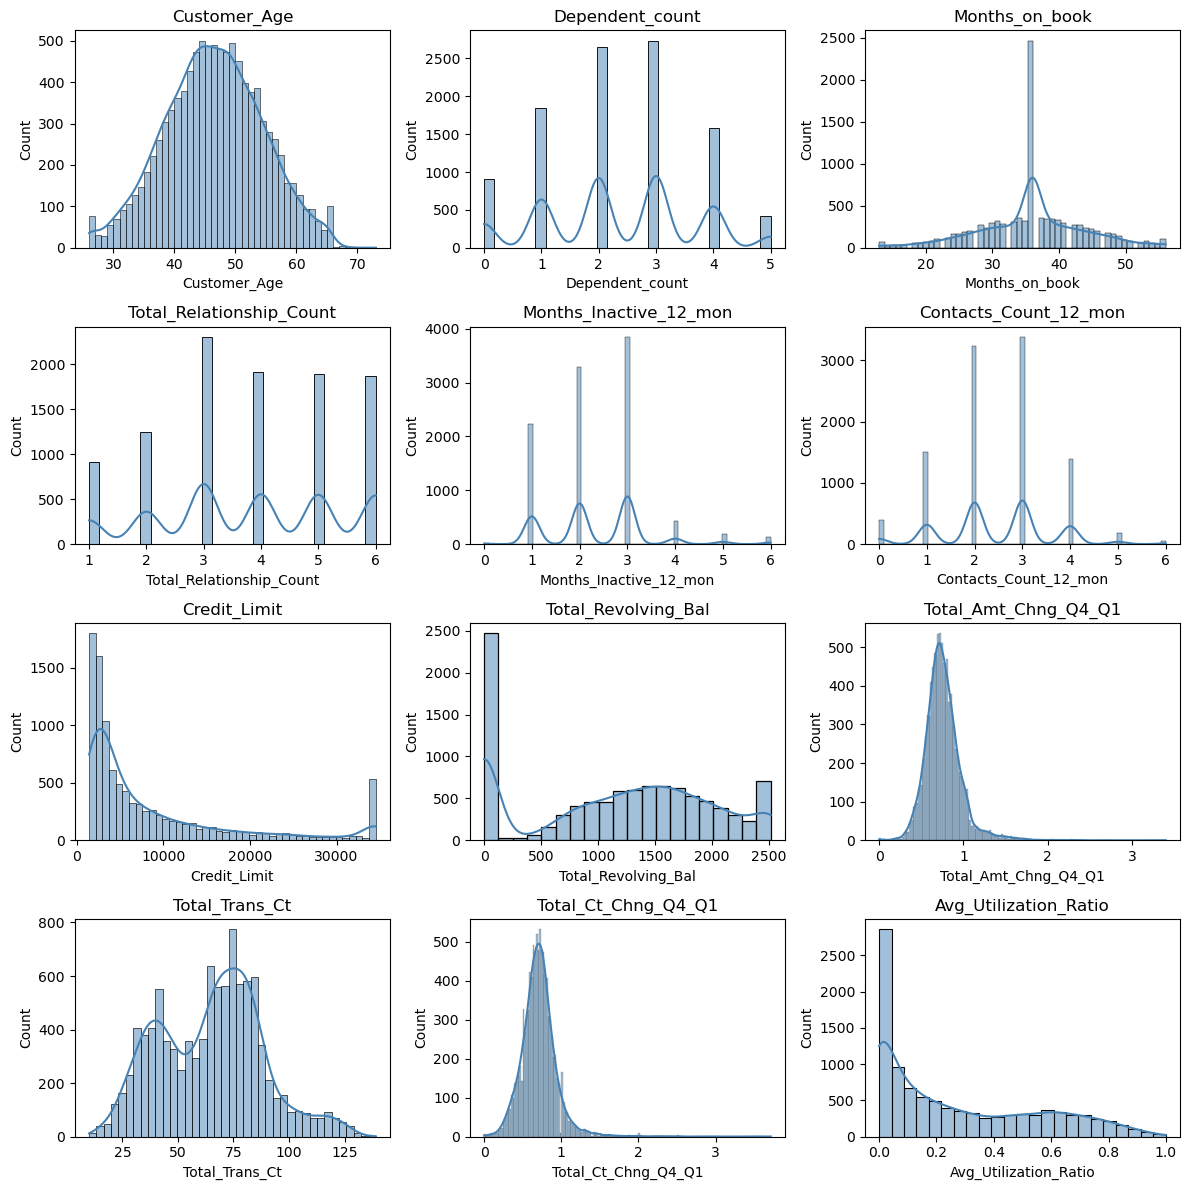

In [11]:
# Verificamos la distribución y si hay presencia de sesgo por outliers
outliers_columnas = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
                     'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
                     'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct',
                     'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

for i, columna in enumerate(outliers_columnas):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.histplot(newbankchurn[columna], kde=True, ax=ax, color='steelblue')
    ax.set_title(columna)

plt.tight_layout()
plt.show()

In [12]:
# TRATAMIENTO DE OUTLIERS

# Identificamos los outliers y los reemplazamos por NaN
for columna in outliers_columnas:
    q1 = newbankchurn[columna].quantile(0.25)
    q3 = newbankchurn[columna].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    newbankchurn.loc[(newbankchurn[columna] < lower_bound) | (newbankchurn[columna] > upper_bound), columna] = np.nan

# Reemplazamos los NaN por la mediana de cada variable
newbankchurn[outliers_columnas] = newbankchurn[outliers_columnas].fillna(newbankchurn[outliers_columnas].median())

In [13]:
# Calculamos los límites de los valores atípicos para cada variable
for columna in outliers_columnas:
    q1 = newbankchurn[columna].quantile(0.25)
    q3 = newbankchurn[columna].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Contamos los valores atípicos
    outliers = newbankchurn[(newbankchurn[columna] < lower_bound) | (newbankchurn[columna] > upper_bound)]
    num_outliers = len(outliers)

    print(f'Variable: {columna}')
    print(f'Número de valores atípicos: {num_outliers}')
    print(f'Límite inferior: {lower_bound}')
    print(f'Límite superior: {upper_bound}')
    print()

Variable: Customer_Age
Número de valores atípicos: 0
Límite inferior: 24.5
Límite superior: 68.5

Variable: Dependent_count
Número de valores atípicos: 0
Límite inferior: -2.0
Límite superior: 6.0

Variable: Months_on_book
Número de valores atípicos: 199
Límite inferior: 20.0
Límite superior: 52.0

Variable: Total_Relationship_Count
Número de valores atípicos: 0
Límite inferior: 0.0
Límite superior: 8.0

Variable: Months_Inactive_12_mon
Número de valores atípicos: 0
Límite inferior: 0.5
Límite superior: 4.5

Variable: Contacts_Count_12_mon
Número de valores atípicos: 0
Límite inferior: 0.5
Límite superior: 4.5

Variable: Credit_Limit
Número de valores atípicos: 794
Límite inferior: -5074.75
Límite superior: 15271.25

Variable: Total_Revolving_Bal
Número de valores atípicos: 0
Límite inferior: -1778.5
Límite superior: 3921.5

Variable: Total_Amt_Chng_Q4_Q1
Número de valores atípicos: 111
Límite inferior: 0.32250000000000006
Límite superior: 1.1504999999999999

Variable: Total_Trans_Ct
N

In [14]:
# Aunque hemos tratado los outliers para no eliminar información relevante, aún quedan valores atípicos pero no se eliminarán
# porque aparte de que podríamos introducir sesgo, también está el hecho de que el dataset está desbaleanceado porque una de las
# clases de la variable objetivo presenta mayor cantidad de datos que la otra, por ende, corremos el riesgo de eliminar una
# cantidad significativa de datos de la clase minoritaria si eliminamos los valores atípicos.

In [15]:
# Feature matrix
X = newbankchurn.drop('Attrition_Flag', 1)
# Target feature
y = newbankchurn['Attrition_Flag']

newbankchurn.head()

C:\Users\User\AppData\Local\Temp\ipykernel_17724\3927614656.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = newbankchurn.drop('Attrition_Flag', 1)


,ClientNum,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45.0,1,3.0,2,2,3,1,39.0,5.0,1.0,3.0,12691.0,777.0,0.731,42.0,0.697,0.061
1,818770008,0,49.0,0,5.0,4,1,1,1,44.0,6.0,1.0,2.0,8256.0,864.0,0.731,33.0,0.697,0.105
2,713982108,0,51.0,1,3.0,4,2,4,1,36.0,4.0,1.0,3.0,3418.0,0.0,0.731,20.0,0.697,0.000
3,769911858,0,40.0,0,4.0,2,4,1,1,34.0,3.0,4.0,1.0,3313.0,2517.0,0.731,20.0,0.697,0.760
4,709106358,0,40.0,1,3.0,1,2,3,1,21.0,5.0,1.0,3.0,4716.0,0.0,0.731,28.0,0.697,0.000


In [16]:
# Implementamos la función creada en clase para obtener las características más significativas mediante el forward selection

import statsmodels.api as sm
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.Logit(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [17]:
forward_selection(X,y)

C:\Users\User\AppData\Local\Temp\ipykernel_17724\262934958.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\User\AppData\Local\Temp\ipykernel_17724\262934958.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


Optimization terminated successfully.
         Current function value: 0.392723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422874
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439650
  

C:\Users\User\AppData\Local\Temp\ipykernel_17724\262934958.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


Optimization terminated successfully.
         Current function value: 0.311536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.325885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.326121
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.326073
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.324856
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.326083
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.323578
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.323351
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.324879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.325895
  

C:\Users\User\AppData\Local\Temp\ipykernel_17724\262934958.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\User\AppData\Local\Temp\ipykernel_17724\262934958.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


Optimization terminated successfully.
         Current function value: 0.285937
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274886
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.286670
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.286623
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286867
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.286841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286489
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.285961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286530
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.286050
  

C:\Users\User\AppData\Local\Temp\ipykernel_17724\262934958.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


Optimization terminated successfully.
         Current function value: 0.272496
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274015
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274685
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274884
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274362
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274489
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274070
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274470
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274161
  

C:\Users\User\AppData\Local\Temp\ipykernel_17724\262934958.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\User\AppData\Local\Temp\ipykernel_17724\262934958.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


Optimization terminated successfully.
         Current function value: 0.268978
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.269815
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.269645
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.269536
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.269312
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.269464
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268777
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.269414
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268975
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.269771
  

C:\Users\User\AppData\Local\Temp\ipykernel_17724\262934958.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


Optimization terminated successfully.
         Current function value: 0.267916
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268775
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268605
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268678
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268287
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268428
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268387
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267973
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268727
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268721
  

C:\Users\User\AppData\Local\Temp\ipykernel_17724\262934958.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\User\AppData\Local\Temp\ipykernel_17724\262934958.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


Optimization terminated successfully.
         Current function value: 0.267915
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267734
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267371
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267599
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267649
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267124
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267865
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267124
  

C:\Users\User\AppData\Local\Temp\ipykernel_17724\262934958.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


Optimization terminated successfully.
         Current function value: 0.266377
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.266477
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.266424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.266393
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.266484
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.266473
         Iterations 8


['Total_Trans_Ct',
 'Total_Revolving_Bal',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Total_Ct_Chng_Q4_Q1',
 'Contacts_Count_12_mon',
 'Gender',
 'Card_Category',
 'ClientNum',
 'Dependent_count',
 'Total_Amt_Chng_Q4_Q1']

In [18]:
# Construimos el nuevo df con las variables seleccionadas más la variable objetivo aunque no se tomará en cuenta 'ClientNum'
# ya que no es un predictor relevante para la rotación de clientes porque sólo es el identificador del cliente

newdata = newbankchurn[['Attrition_Flag', 'Total_Trans_Ct', 'Total_Revolving_Bal', 'Total_Relationship_Count',
                        'Months_Inactive_12_mon', 'Total_Ct_Chng_Q4_Q1', 'Gender', 'Contacts_Count_12_mon',
                        'Dependent_count', 'Total_Amt_Chng_Q4_Q1', 'Card_Category']].copy()

In [19]:
# MUESTREAMOS LOS DATOS, CONSTRUYENDO UN DATASET DE TRAIN Y TEST

In [20]:
# Muestreo estratificado en función de la variable respuesta para que en los splits sus categorías estén bien representadas.
# Split 70/30.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(newdata.drop('Attrition_Flag', axis=1), newdata.Attrition_Flag, 
                                                    test_size = 0.3, random_state = 0, stratify = newdata.Attrition_Flag)

In [22]:
# Construimos un modelo analítico de clasificación que sea capaz de predecir cuando un cliente se fuga del banco

def metricas(y_real, y_pred): 
    false_positive_rate, recall, thresholds = roc_curve(y_real, y_pred)
    roc_auc = auc(false_positive_rate, recall)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

In [23]:
# MODELO DE ML PARA CLASIFICACIÓN

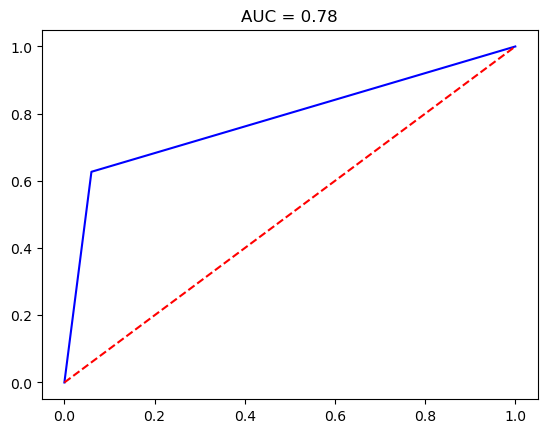

In [24]:
# Decision Tree
classifier1 = DecisionTreeClassifier(criterion='gini').fit(X_train, y_train)
pred1 = classifier1.predict(X_test)

# Métricas:
metricas(y_test, pred1)

In [25]:
# Rendimiento del modelo
r2 = r2_score(y_test, pred1)
print('R2:', r2)

# Error absoluto medio
print('MAE:', mean_absolute_error(y_test, pred1))

# Error cuadrático medio
print('MSE:', mean_squared_error(y_test, pred1))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred1)))

R2: 0.18220353959552982
MAE: 0.1102336294833827
MSE: 0.1102336294833827
RMSE: 0.33201450191728477


In [26]:
# El modelo obtuvo un buen rendimiento en términos de capacidad de predicción, al obtener un AUC de 0.78 y el valor del R2 
# indica que el modelo puede explicar el 18.22% de la variabilidad en la variable objetivo. En cuanto a las métricas de error
# (MAE, MSE y RMSE) sus valores son relativamente bajos. Sin embargo, el valor de R2 sugiere que el modelo aún puede mejorarse
# porque hay un gran porcentaje de variabilidad en los datos que no está siendo capturado o explicado por el modelo.

<Figure size 800x600 with 0 Axes>

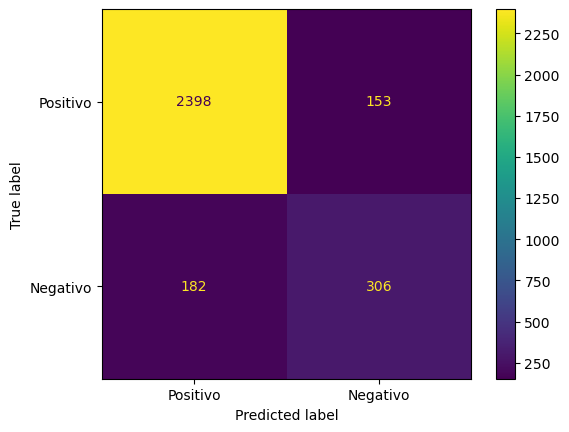

In [27]:
# Matriz de confusión
cm = confusion_matrix(y_test, pred1, labels=classifier1.classes_)
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positivo','Negativo'])
disp.plot()

In [28]:
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2551
           1       0.67      0.63      0.65       488

    accuracy                           0.89      3039
   macro avg       0.80      0.78      0.79      3039
weighted avg       0.89      0.89      0.89      3039



In [29]:
# Los resultados del classification report indican que el modelo está funcionando bien aunque la clasificación de la clase 0 es
# la que presenta un mejor rendimiento comparada con la clase 1. 

# La precisión para la clase 0 es de 0.93, lo que indica que el 93% de las predicciones clasificadas como clase 0 son 
# realmente correctas. Para la clase 1, la precisión es de 0.67, lo que implica que el 67% de las predicciones clasificadas
# como clase 1 son correctas.

# El recall para la clase 0 es de 0.94, lo que significa que el 94% de las instancias de la clase 0 se identifican 
# correctamente. Para la clase 1, el recall es de 0.63, lo que indica que sólo se identifica correctamente el 63% de las 
# instancias de la clase 1.

# Para la clase 0, el f1-score es de 0.93, mientras que para la clase 1 es de 0.65 y sabemos que un F1-score más alto indica
# un mejor equilibrio entre precisión y recall. En este caso, el modelo tiene dificultades para clasificar correctamente las
# instancias de la clase 1.

# El accuracy del modelo es del 89%, lo que indica el porcentaje de predicciones correctas sobre el total de instancias.

In [30]:
# Validación cruzada
cv = cross_val_score(classifier1, X_train, y_train, scoring = 'roc_auc', cv = 5)
print('Valores ROC AUC para cada fold:', cv)
print('Promedio CV ROC:', cv.mean())
print('Desviación Estándar CV ROC:', np.std(cv))

Valores ROC AUC para cada fold: [0.76971473 0.79659443 0.79440144 0.78491652 0.7987602 ]
Promedio CV ROC: 0.7888774642387414
Desviación Estándar CV ROC: 0.010683013259089772


In [31]:
# Los valores obtenidos indican que el modelo tiene un rendimiento aceptable en términos de la capacidad de distinguir entre las
# clases y presenta una consistencia razonable en su rendimiento en diferentes folds.

In [32]:
# Calculamos el training error
training_error = np.mean(classifier1.predict(X_train) != y_train)

# Calculamos el validation error
validation_error = np.mean(classifier1.predict(X_test) != y_test)

print('Training error:', training_error)
print('Validation error:', validation_error)

Training error: 0.0
Validation error: 0.1102336294833827


In [33]:
# Los resultados indican que modelo tiene una precisión perfecta en el conjunto de entrenamiento, pero presenta un error de 
# validación del 11.02%. Si tomo como límite el 10% entonces es un valor un poco alto por lo que podría considerarse un posible
# overfitting. Una de las posibles razones como se ha comentado previamente es el tamaño actual de la muestra y el desbalance de
# las clases.

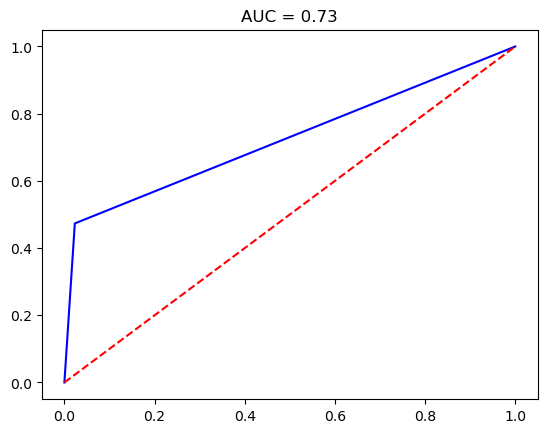

In [34]:
# Linear SVC
classifier2 = LinearSVC(penalty='l1', dual= False).fit(X_train, y_train)
pred2 = classifier2.predict(X_test)

# Métricas
metricas(y_test, pred2)

In [35]:
# Rendimiento del modelo
r2 = r2_score(y_test, pred2)
print('R2:', r2)

# Error absoluto medio
print('MAE:', mean_absolute_error(y_test, pred2))

# Error cuadrático medio
print('MSE:', mean_squared_error(y_test, pred2))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred2)))

R2: 0.22858602540951467
MAE: 0.1039815728858177
MSE: 0.1039815728858177
RMSE: 0.32246173863858285


In [36]:
# El modelo obtuvo un buen rendimiento en términos de capacidad de predicción, al obtener un AUC de 0.73 y el valor del R2 
# indica que el modelo puede explicar el 22.86% de la variabilidad en la variable objetivo. En cuanto a las métricas de error 
# (MAE, MSE y RMSE) sus valores son bajos. Sin embargo, el valor de R2 sugiere que el modelo aún puede mejorarse porque hay un
# gran porcentaje de variabilidad en los datos que no está siendo capturado o explicado por el modelo.

<Figure size 800x600 with 0 Axes>

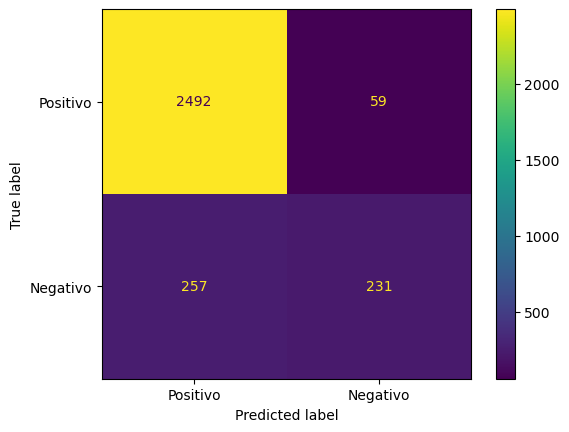

In [37]:
# Matriz de confusión
cm = confusion_matrix(y_test, pred2, labels=classifier2.classes_)
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positivo','Negativo'])
disp.plot()

In [38]:
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2551
           1       0.80      0.47      0.59       488

    accuracy                           0.90      3039
   macro avg       0.85      0.73      0.77      3039
weighted avg       0.89      0.90      0.88      3039



In [39]:
# Los resultados del classification report indican que el modelo está funcionando bien aunque la clasificación de la clase 0 es
# la que presenta un mejor rendimiento comparada con la clase 1. 

# La precisión para la clase 0 es de 0.91, lo que indica que el 91% de las predicciones clasificadas como clase 0 son 
# realmente correctas. Para la clase 1, la precisión es de 0.80, lo que implica que el 80% de las predicciones clasificadas 
# como clase 1 son correctas.

# El recall para la clase 0 es de 0.98, lo que significa que el 98% de las instancias de la clase 0 se identifican 
# correctamente. Para la clase 1, el recall es de 0.47, lo que indica que sólo se identifica correctamente el 47% de las 
# instancias de la clase 1.

# Para la clase 0, el f1-score es de 0.94, mientras que para la clase 1 es de 0.59 y sabemos que un F1-score más alto indica
# un mejor equilibrio entre precisión y recall. En este caso, el modelo tiene dificultades para clasificar correctamente las 
# instancias de la clase 1.

# El accuracy del modelo es del 90%, lo que indica el porcentaje de predicciones correctas sobre el total de instancias.

In [40]:
# Validación cruzada
cv = cross_val_score(classifier2, X_train, y_train, scoring = 'roc_auc', cv = 5)
print('Valores ROC AUC para cada fold:', cv)
print('Promedio CV ROC:', cv.mean())
print('Desviación Estándar CV ROC:', np.std(cv))

Valores ROC AUC para cada fold: [0.88590226 0.88587646 0.90478402 0.89463962 0.90261977]
Promedio CV ROC: 0.8947644246307217
Desviación Estándar CV ROC: 0.007995603800321556


In [41]:
# Los valores obtenidos indican que el modelo tiene un buen rendimiento en términos de la capacidad de distinguir entre las 
# clases y presenta una consistencia razonable en su rendimiento en diferentes folds.

In [42]:
# Calculamos el training error
training_error = np.mean(classifier2.predict(X_train) != y_train)

# Calculamos el validation error
validation_error = np.mean(classifier2.predict(X_test) != y_test)

print('Training error:', training_error)
print('Validation error:', validation_error)

Training error: 0.10567155756207675
Validation error: 0.1039815728858177


In [43]:
# Los resultados indican que modelo ha clasificado incorrectamente aproximadamente el 10.57% de los ejemplos en el conjunto de
# entrenamiento y también ha clasificado incorrectamente aproximadamente el 10.40% de los ejemplos en el conjunto de validación.
# Ambos presentan un valor de error similar; sin embargo, es importante tomar en cuenta que el 'training error' me indica que el
# modelo todavía comete errores al clasificar los datos.

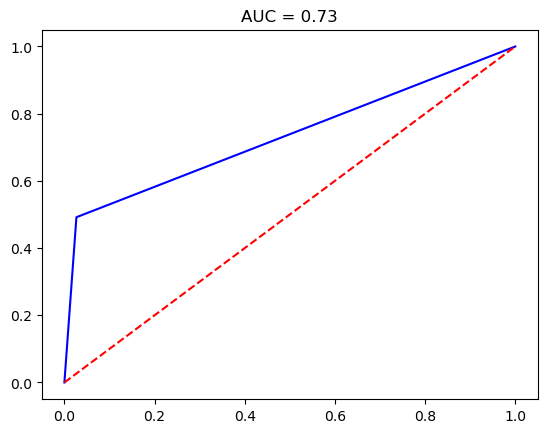

In [44]:
# Logistic Regression
classifier3 = LogisticRegression(max_iter=10000).fit(X_train, y_train)
pred3 = classifier3.predict(X_test)

# Métricas
metricas(y_test, pred3)

In [45]:
# Rendimiento del modelo
r2 = r2_score(y_test, pred3)
print('R2:', r2)

# Error absoluto medio
print('MAE:', mean_absolute_error(y_test, pred3))

# Error cuadrático medio
print('MSE:', mean_squared_error(y_test, pred3))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred3)))

R2: 0.22858602540951467
MAE: 0.1039815728858177
MSE: 0.1039815728858177
RMSE: 0.32246173863858285


In [46]:
# El modelo obtuvo un buen rendimiento en términos de capacidad de predicción, al obtener un AUC de 0.73 y el valor del R2 
# indica que el modelo puede explicar el 22.86% de la variabilidad en la variable objetivo. En cuanto a las métricas de error 
# (MAE, MSE y RMSE) sus valores son bajos. Sin embargo, el valor de R2 sugiere que el modelo aún puede mejorarse porque hay un 
# gran porcentaje de variabilidad en los datos que no está siendo capturado o explicado por el modelo.

<Figure size 800x600 with 0 Axes>

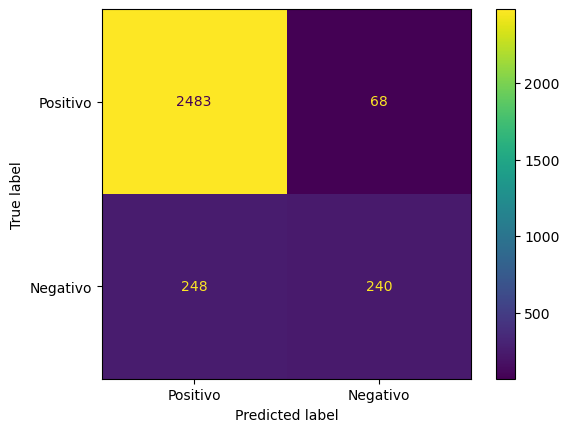

In [47]:
# Matriz de confusión
cm = confusion_matrix(y_test, pred3, labels=classifier3.classes_)
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positivo','Negativo'])
disp.plot()

In [48]:
print(classification_report(y_test, pred3))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2551
           1       0.78      0.49      0.60       488

    accuracy                           0.90      3039
   macro avg       0.84      0.73      0.77      3039
weighted avg       0.89      0.90      0.89      3039



In [49]:
# Los resultados del classification report indican que el modelo está funcionando bien aunque la clasificación de la clase 0 es
# la que presenta un mejor rendimiento comparada con la clase 1. 

# La precisión para la clase 0 es de 0.91, lo que indica que el 91% de las predicciones clasificadas como clase 0 son 
# realmente correctas. Para la clase 1, la precisión es de 0.78, lo que implica que el 78% de las predicciones clasificadas
# como clase 1 son correctas.

# El recall para la clase 0 es de 0.97 lo que significa que el 97% de las instancias de la clase 0 se identifican correctamente.
# Para la clase 1, el recall es de 0.49 lo cual i sólo se identifica correctamente el 49% de las instancias de esa clase

# Para la clase 0, el f1-score es de 0.94, mientras que para la clase 1 es de 0.60 y sabemos que un F1-score más alto indica
# un mejor equilibrio entre precisión y recall. En este caso, el modelo tiene dificultades para clasificar correctamente las
# instancias de la clase 1.

# El accuracy del modelo es del 90%, lo que indica el porcentaje de predicciones correctas sobre el total de instancias.

In [50]:
# Validación cruzada
cv = cross_val_score(classifier3, X_train, y_train, scoring = 'roc_auc', cv = 5)
print('Valores ROC AUC para cada fold:', cv)
print('Promedio CV ROC:', cv.mean())
print('Desviación Estándar CV ROC:', np.std(cv))

Valores ROC AUC para cada fold: [0.88690845 0.88619711 0.9055359  0.89553178 0.90400307]
Promedio CV ROC: 0.8956352613291545
Desviación Estándar CV ROC: 0.008164428980547422


In [51]:
# Los valores obtenidos indican que el modelo tiene un buen rendimiento en términos de la capacidad de distinguir entre las 
# clases y presenta una consistencia razonable en su rendimiento en diferentes folds.

In [52]:
# Calculamos el training error
training_error = np.mean(classifier3.predict(X_train) != y_train)

# Calculamos el validation error
validation_error = np.mean(classifier3.predict(X_test) != y_test)

print('Training error:', training_error)
print('Validation error:', validation_error)

Training error: 0.10736455981941309
Validation error: 0.1039815728858177


In [53]:
# Los resultados indican que modelo ha clasificado incorrectamente aproximadamente el 10.74% de los ejemplos en el conjunto de
# entrenamiento y también ha clasificado incorrectamente aproximadamente el 10.40% de los ejemplos en el conjunto de validación.
# Ambos presentan un valor de error similar; sin embargo, es importante tomar en cuenta que 'training error' me indica que el 
# modelo todavía comete errores al clasificar los datos.

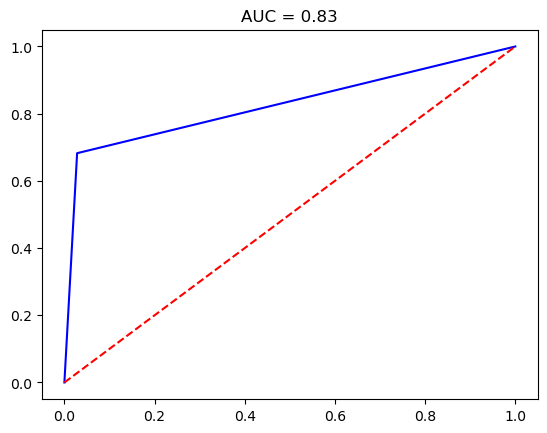

In [54]:
# XGBoost Classifier
classifier4 = XGBClassifier().fit(X_train, y_train)
pred4 = classifier4.predict(X_test)

# Métricas:
metricas(y_test, pred4)

In [55]:
# Rendimiento del modelo
r2 = r2_score(y_test, pred4)
print('R2:', r2)

# Error absoluto medio
print('MAE:', mean_absolute_error(y_test, pred4))

# Error cuadrático medio
print('MSE:', mean_squared_error(y_test, pred4))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred4)))

R2: 0.4458513536960754
MAE: 0.0746956235603817
MSE: 0.0746956235603817
RMSE: 0.2733050009794583


In [56]:
# El modelo obtuvo un buen rendimiento en términos de capacidad de predicción, al obtener un AUC de 0.83 y el valor del R2 
# indica que el modelo puede explicar el 44.59% de la variabilidad en la variable objetivo. En cuanto a las métricas de error
# (MAE, MSE y RMSE) sus valores son bajos. Sin embargo, el valor de R2 sugiere que el modelo aún puede mejorarse porque hay un 
# gran porcentaje de variabilidad en los datos que no está siendo capturado o explicado por el modelo.

<Figure size 800x600 with 0 Axes>

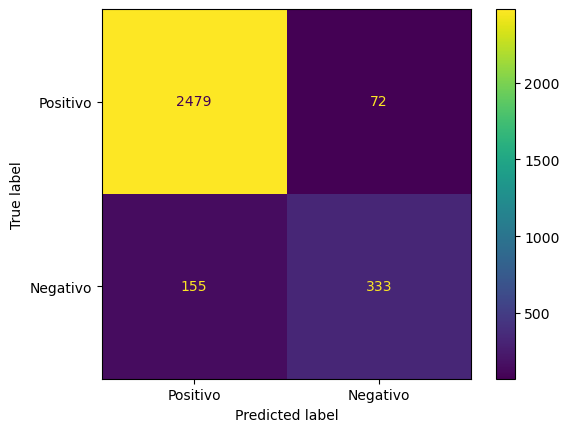

In [57]:
# Matriz de confusión
cm = confusion_matrix(y_test, pred4, labels=classifier4.classes_)
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positivo','Negativo'])
disp.plot()

In [58]:
print(classification_report(y_test, pred4))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2551
           1       0.82      0.68      0.75       488

    accuracy                           0.93      3039
   macro avg       0.88      0.83      0.85      3039
weighted avg       0.92      0.93      0.92      3039



In [59]:
# Los resultados del classification report indican que el modelo está funcionando bien aunque la clasificación de la clase 0 es
# la que presenta un mejor rendimiento comparada con la clase 1. 

# La precisión para la clase 0 es de 0.94, lo que indica que el 94% de las predicciones clasificadas como clase 0 son 
# realmente correctas. Para la clase 1, la precisión es de 0.82, lo que implica que el 82% de las predicciones clasificadas
# como clase 1 son correctas.

# El recall para la clase 0 es de 0.97, lo que significa que el 97% de las instancias de la clase 0 se identifican 
# correctamente. Para la clase 1, el recall es de 0.68, lo que indica que sólo se identifica correctamente el 68% de las 
# instancias de la clase 1.

# Para la clase 0, el f1-score es de 0.96, mientras que para la clase 1 es de 0.75 y sabemos que un F1-score más alto indica
# un mejor equilibrio entre precisión y recall. En este caso, el modelo tiene dificultades para clasificar correctamente las
# instancias de la clase 1.

# El accuracy del modelo es del 93%, lo que indica el porcentaje de predicciones correctas sobre el total de instancias.

In [60]:
# Validación cruzada
cv = cross_val_score(classifier4, X_train, y_train, scoring = 'roc_auc', cv = 5)
print('Valores ROC AUC para cada fold:', cv)
print('Promedio CV ROC:', cv.mean())
print('Desviación Estándar CV ROC:', np.std(cv))

Valores ROC AUC para cada fold: [0.93928571 0.94987469 0.95883459 0.95001666 0.95059611]
Promedio CV ROC: 0.9497215507417958
Desviación Estándar CV ROC: 0.006210144791261197


In [61]:
# Los valores obtenidos indican que el modelo tiene un buen rendimiento en términos de la capacidad de distinguir entre las 
# clases y presenta una consistencia razonable en su rendimiento en diferentes folds.

In [62]:
# Calculamos el training error
training_error = np.mean(classifier4.predict(X_train) != y_train)

# Calculamos el validation error
validation_error = np.mean(classifier4.predict(X_test) != y_test)

print('Training error:', training_error)
print('Validation error:', validation_error)

Training error: 0.004655756207674944
Validation error: 0.0746956235603817


In [63]:
# Los resultados indican que modelo ha clasificado incorrectamente aproximadamente el 0.47% de los ejemplos en el conjunto de
# entrenamiento y también ha clasificado incorrectamente aproximadamente el 7.47% de los ejemplos en el conjunto de validación.
# Es importante tomar en cuenta que 'training error' me indica que el modelo todavía comete errores al clasificar los datos.

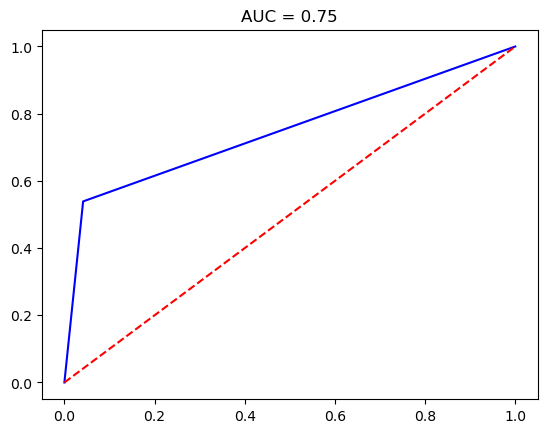

In [64]:
# Gaussian Naive Bayes
classifier5 = GaussianNB().fit(X_train, y_train)
pred5 = classifier5.predict(X_test)

# Métricas
metricas(y_test, pred5)

In [65]:
# Rendimiento del modelo
r2 = r2_score(y_test, pred5)
print('R2:', r2)

# Error absoluto medio
print('MAE:', mean_absolute_error(y_test, pred5))

# Error cuadrático medio
print('MSE:', mean_squared_error(y_test, pred5))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred5)))

R2: 0.19196827345110556
MAE: 0.10891740704179007
MSE: 0.10891740704179007
RMSE: 0.3300263732518813


In [66]:
# El modelo obtuvo un rendimiento aceptable en términos de capacidad de predicción, al obtener un AUC de 0.75 y el valor del R2
# indica que el modelo puede explicar el 19.20% de la variabilidad en la variable objetivo. En cuanto a las métricas de error 
# (MAE, MSE y RMSE) sus valores son bajos. Sin embargo, el valor de R2 sugiere que el modelo aún puede mejorarse porque hay un 
# gran porcentaje de variabilidad en los datos que no está siendo capturado o explicado por el modelo.

<Figure size 800x600 with 0 Axes>

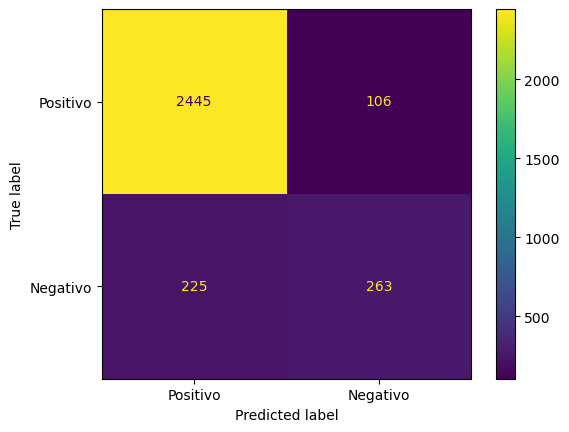

In [67]:
# Matriz de confusión
cm = confusion_matrix(y_test, pred5, labels=classifier5.classes_)
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positivo','Negativo'])
disp.plot()

In [68]:
print(classification_report(y_test, pred5))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2551
           1       0.71      0.54      0.61       488

    accuracy                           0.89      3039
   macro avg       0.81      0.75      0.78      3039
weighted avg       0.88      0.89      0.88      3039



In [69]:
# Los resultados del classification report indican que el modelo está funcionando bien aunque la clasificación de la clase 0 es
# la que presenta un mejor rendimiento comparada con la clase 1. 

# La precisión para la clase 0 es de 0.92, lo que indica que el 92% de las predicciones clasificadas como clase 0 son 
# realmente correctas. Para la clase 1, la precisión es de 0.71, lo que implica que el 71% de las predicciones clasificadas
# como clase 1 son correctas.

# El recall para la clase 0 es de 0.96, lo que significa que el 96% de las instancias de la clase 0 se identifican 
# correctamente. Para la clase 1, el recall es de 0.54, lo que indica que sólo se identifica correctamente el 54% de las
# instancias de la clase 1.

# Para la clase 0, el f1-score es de 0.94, mientras que para la clase 1 es de 0.61 y sabemos que un F1-score más alto indica
# un mejor equilibrio entre precisión y recall. En este caso, el modelo tiene dificultades para clasificar correctamente las
# instancias de la clase 1.

# El accuracy del modelo es del 89%, lo que indica el porcentaje de predicciones correctas sobre el total de instancias.

In [70]:
# Validación cruzada
cv = cross_val_score(classifier5, X_train, y_train, scoring = 'roc_auc', cv = 5)
print('Valores ROC AUC para cada fold:', cv)
print('Promedio CV ROC:', cv.mean())
print('Desviación Estándar CV ROC:', np.std(cv))

Valores ROC AUC para cada fold: [0.87883311 0.90554327 0.89611897 0.90112538 0.91043262]
Promedio CV ROC: 0.8984106721543261
Desviación Estándar CV ROC: 0.010874774414067357


In [71]:
# Los valores obtenidos indican que el modelo tiene un buen rendimiento en términos de la capacidad de distinguir entre las
# clases y presenta una consistencia razonable en su rendimiento en diferentes folds.

In [72]:
# Calculamos el training error
training_error = np.mean(classifier5.predict(X_train) != y_train)

# Calculamos el validation error
validation_error = np.mean(classifier5.predict(X_test) != y_test)

print('Training error:', training_error)
print('Validation error:', validation_error)

Training error: 0.110186230248307
Validation error: 0.10891740704179007


In [73]:
# Los resultados indican que modelo ha clasificado incorrectamente aproximadamente el 11.02% de los ejemplos en el conjunto de
# entrenamiento y también ha clasificado incorrectamente aproximadamente el 10.89% de los ejemplos en el conjunto de validación.
# Ambos valores de error se asemejan pero es importante tomar en cuenta que 'training error' me indica que el modelo todavía 
# comete errores al clasificar los datos.

C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


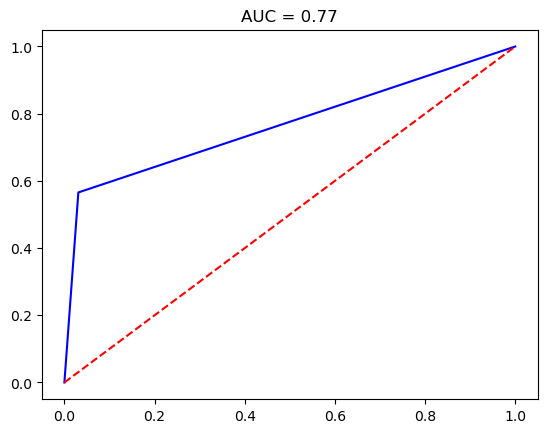

In [74]:
# K-Nearest Neighbors (KNN)
classifier6 = KNeighborsClassifier().fit(X_train, y_train)
pred6 = classifier6.predict(X_test)

# Métricas
metricas(y_test, pred6)

In [75]:
# Rendimiento del modelo
r2 = r2_score(y_test, pred6)
print('R2:', r2)

# Error absoluto medio
print('MAE:', mean_absolute_error(y_test, pred6))

# Error cuadrático medio
print('MSE:', mean_squared_error(y_test, pred6))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred6)))

R2: 0.28961561200686325
MAE: 0.09575518262586377
MSE: 0.09575518262586377
RMSE: 0.3094433431597193


In [76]:
# El modelo obtuvo un rendimiento aceptable en términos de capacidad de predicción, al obtener un AUC de 0.77 y el valor del R2
# indica que el modelo puede explicar el 28.96% de la variabilidad en la variable objetivo. En cuanto a las métricas de error 
# (MAE, MSE y RMSE) sus valores son bajos. Sin embargo, el valor de R2 sugiere que el modelo aún puede mejorarse porque hay un 
# gran porcentaje de variabilidad en los datos que no está siendo capturado o explicado por el modelo.

<Figure size 800x600 with 0 Axes>

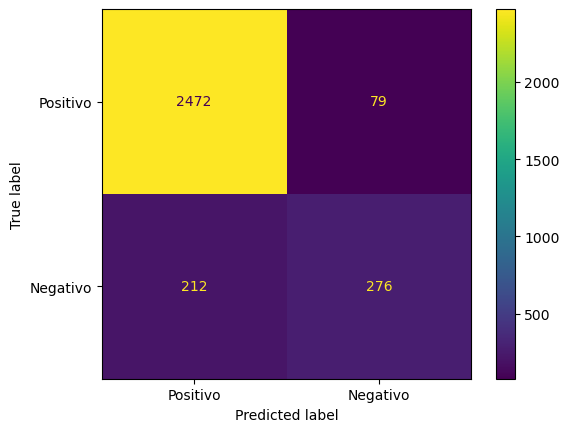

In [77]:
# Matriz de confusión
cm = confusion_matrix(y_test, pred6, labels=classifier6.classes_)
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positivo','Negativo'])
disp.plot()

In [78]:
print(classification_report(y_test, pred6))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2551
           1       0.78      0.57      0.65       488

    accuracy                           0.90      3039
   macro avg       0.85      0.77      0.80      3039
weighted avg       0.90      0.90      0.90      3039



In [79]:
# Los resultados del classification report indican que el modelo está funcionando bien aunque la clasificación de la clase 0 es
# la que presenta un mejor rendimiento comparada con la clase 1. 

# La precisión para la clase 0 es de 0.92, lo que indica que el 92% de las predicciones clasificadas como clase 0 son 
# realmente correctas. Para la clase 1, la precisión es de 0.78, lo que implica que el 78% de las predicciones clasificadas 
# como clase 1 son correctas.

# El recall para la clase 0 es de 0.96, lo que significa que el 97% de las instancias de la clase 0 se identifican 
# correctamente. Para la clase 1, el recall es de 0.57, lo que indica que sólo se identifica correctamente el 60% de las
# instancias de la clase 1.

# Para la clase 0, el f1-score es de 0.94, mientras que para la clase 1 es de 0.65 y sabemos que un F1-score más alto indica
# un mejor equilibrio entre precisión y recall. En este caso, el modelo tiene dificultades para clasificar correctamente las
# instancias de la clase 1.

# El accuracy del modelo es del 90%, lo que indica el porcentaje de predicciones correctas sobre el total de instancias.

In [80]:
# Validación cruzada
cv = cross_val_score(classifier6, X_train, y_train, scoring = 'roc_auc', cv = 5)
print('Valores ROC AUC para cada fold:', cv)
print('Promedio CV ROC:', cv.mean())
print('Desviación Estándar CV ROC:', np.std(cv))

Valores ROC AUC para cada fold: [0.82516586 0.8427521  0.86270271 0.85099582 0.84548972]
Promedio CV ROC: 0.8454212418390691
Desviación Estándar CV ROC: 0.012224031957426773


In [81]:
# Los valores obtenidos indican que el modelo tiene un buen rendimiento en términos de la capacidad de distinguir entre las 
# clases y presenta una consistencia razonable en su rendimiento en diferentes folds.

In [82]:
# Calculamos el training error
training_error = np.mean(classifier6.predict(X_train) != y_train)

# Calculamos el validation error
validation_error = np.mean(classifier6.predict(X_test) != y_test)

print('Training error:', training_error)
print('Validation error:', validation_error)

C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Training error: 0.08140519187358916
Validation error: 0.09575518262586377


C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [83]:
# Los resultados indican que modelo ha clasificado incorrectamente aproximadamente el 8.14% de los ejemplos en el conjunto de 
# entrenamiento y también ha clasificado incorrectamente aproximadamente el 9.58% de los ejemplos en el conjunto de validación.
# No olvidar que el 'training error' me indica que el modelo todavía comete errores al clasificar los datos.

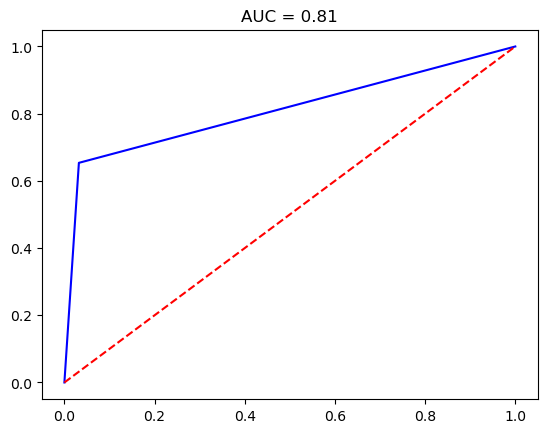

In [84]:
# AdaBoost
classifier7 = AdaBoostClassifier().fit(X_train, y_train)
pred7 = classifier7.predict(X_test)

# Métricas
metricas(y_test, pred7)

In [85]:
# Rendimiento del modelo
r2 = r2_score(y_test, pred7)
print('R2:', r2)

# Error absoluto medio
print('MAE:', mean_absolute_error(y_test, pred7))

# Error cuadrático medio
print('MSE:', mean_squared_error(y_test, pred7))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred7)))

R2: 0.38726295056262083
MAE: 0.08259295820993748
MSE: 0.08259295820993748
RMSE: 0.28738990624226435


In [86]:
# El modelo obtuvo un buen rendimiento en términos de capacidad de predicción, al obtener un AUC de 0.81 y el valor del R2 
# indica que el modelo puede explicar el 38.73% de la variabilidad en la variable objetivo. En cuanto a las métricas de error 
# (MAE, MSE y RMSE) sus valores son bajos. Sin embargo, el valor de R2 sugiere que el modelo aún puede mejorarse porque hay un
# gran porcentaje de variabilidad en los datos que no está siendo capturado o explicado por el modelo.

<Figure size 800x600 with 0 Axes>

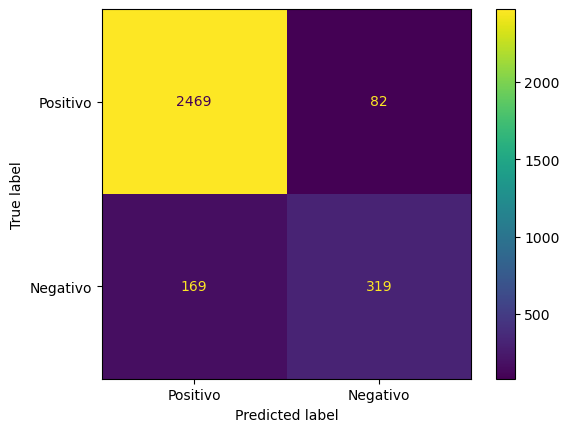

In [87]:
# Matriz de confusión
cm = confusion_matrix(y_test, pred7, labels=classifier7.classes_)
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positivo','Negativo'])
disp.plot()

In [88]:
print(classification_report(y_test, pred7))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2551
           1       0.80      0.65      0.72       488

    accuracy                           0.92      3039
   macro avg       0.87      0.81      0.83      3039
weighted avg       0.91      0.92      0.91      3039



In [89]:
# Los resultados del classification report indican que el modelo está funcionando bien aunque la clasificación de la clase 0 es
# la que presenta un mejor rendimiento comparada con la clase 1. 

# La precisión para la clase 0 es de 0.94, lo que indica que el 94% de las predicciones clasificadas como clase 0 son 
# realmente correctas. Para la clase 1, la precisión es de 0.80, lo que implica que el 80% de las predicciones clasificadas
# como clase 1 son correctas.

# El recall para la clase 0 es de 0.97, lo que significa que el 97% de las instancias de la clase 0 se identifican 
# correctamente. Para la clase 1, el recall es de 0.65, lo que indica que sólo se identifica correctamente el 65% de las 
# instancias de la clase 1.

# Para la clase 0, el f1-score es de 0.95, mientras que para la clase 1 es de 0.72 y sabemos que un F1-score más alto indica
# un mejor equilibrio entre precisión y recall. En este caso, el modelo tiene dificultades para clasificar correctamente las 
# instancias de la clase 1.

# El accuracy del modelo es del 92%, lo que indica el porcentaje de predicciones correctas sobre el total de instancias.

In [90]:
# Validación cruzada
cv = cross_val_score(classifier7, X_train, y_train, scoring = 'roc_auc', cv = 5)
print('Valores ROC AUC para cada fold:', cv)
print('Promedio CV ROC:', cv.mean())
print('Desviación Estándar CV ROC:', np.std(cv))

Valores ROC AUC para cada fold: [0.92688338 0.93972431 0.94718229 0.93783364 0.93886024]
Promedio CV ROC: 0.938096772933067
Desviación Estándar CV ROC: 0.006505194302316375


In [91]:
# Los valores obtenidos indican que el modelo tiene un buen rendimiento en términos de la capacidad de distinguir entre las 
# clases y presenta una consistencia razonable en su rendimiento en diferentes folds.

In [92]:
# Calculamos el training error
training_error = np.mean(classifier7.predict(X_train) != y_train)

# Calculamos el validation error
validation_error = np.mean(classifier7.predict(X_test) != y_test)

print('Training error:', training_error)
print('Validation error:', validation_error)

Training error: 0.0774548532731377
Validation error: 0.08259295820993748


In [93]:
# Los resultados indican que modelo ha clasificado incorrectamente aproximadamente el 7.75% de los ejemplos en el conjunto de
# entrenamiento y también ha clasificado incorrectamente aproximadamente el 8.26% de los ejemplos en el conjunto de validación.
# Recordemos que el 'training error' me indica que el modelo todavía comete errores al clasificar los datos.

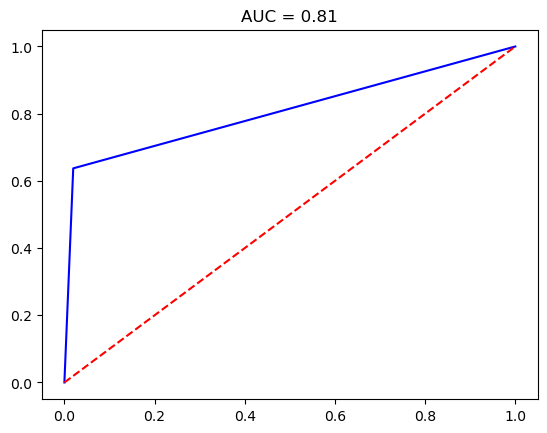

In [94]:
# Random Forest
classifier8 = RandomForestClassifier().fit(X_train, y_train)
pred8 = classifier8.predict(X_test)

# Métricas
metricas(y_test, pred8)

In [95]:
# Rendimiento del modelo
r2 = r2_score(y_test, pred8)
print('R2:', r2)

# Error absoluto medio
print('MAE:', mean_absolute_error(y_test, pred8))

# Error cuadrático medio
print('MSE:', mean_squared_error(y_test, pred8))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred8)))

R2: 0.4458513536960754
MAE: 0.0746956235603817
MSE: 0.0746956235603817
RMSE: 0.2733050009794583


In [96]:
# El modelo obtuvo un buen rendimiento en términos de capacidad de predicción, al obtener un AUC de 0.81 y el valor del R2 
# indica que el modelo puede explicar el 44.59% de la variabilidad en la variable objetivo. En cuanto a las métricas de error
# (MAE, MSE y RMSE) indican que las predicciones del modelo tienen un promedio de diferencia y error relativamente bajos, es 
# decir, que tienen un buen rendimiento en la predicción de valores cercanos a los reales. Sin embargo, el valor de R2 sugiere
# que el modelo aún puede mejorarse para explicar más variabilidad en la variable objetivo.

<Figure size 800x600 with 0 Axes>

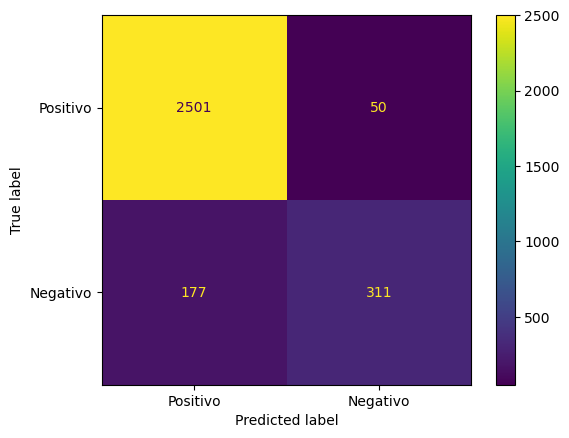

In [97]:
# Matriz de confusión
cm = confusion_matrix(y_test, pred8, labels=classifier8.classes_)
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positivo','Negativo'])
disp.plot()

In [98]:
print(classification_report(y_test, pred8))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      2551
           1       0.86      0.64      0.73       488

    accuracy                           0.93      3039
   macro avg       0.90      0.81      0.84      3039
weighted avg       0.92      0.93      0.92      3039



In [99]:
# Los resultados del classification report indican que el modelo está funcionando bien aunque la clasificación de la clase 0 es
# la que presenta un mejor rendimiento comparada con la clase 1. El F1-score promedio es del 85%, lo que indica un buen 
# equilibrio general entre precision y recall. De forma más detallada tenemos lo siguiente:

# La precisión para la clase 0 es de 0.93, lo que indica que el 93% de las predicciones clasificadas como clase 0 son realmente
# correctas. Para la clase 1, la precisión es de 0.86 lo que implica que el 87% de las predicciones clasificadas como clase 1 
# son correctas.

# El recall para la clase 0 es de 0.98 lo que significa que el 98% de las instancias de la clase 0 se identifican correctamente.
# Para la clase 1, el recall es de 0.64 es decir, sólo se identifica correctamente el 64% de las instancias de esta clase.

# Para la clase 0, el f1-score es de 0.96 mientras que para la clase 1 es de 0.73 y sabemos que un F1-score más alto indica un
# mejor equilibrio entre precisión y recall. En este caso, el modelo tiene dificultades para clasificar correctamente las 
# instancias de la clase 1.

# La exactitud general del modelo (accuracy) es del 93%, lo que indica el porcentaje de predicciones correctas sobre el total
# de instancias.

In [100]:
# Validación cruzada
cv = cross_val_score(classifier8, X_train, y_train, scoring = 'roc_auc', cv = 5)
print('Valores ROC AUC para cada fold:', cv)
print('Promedio CV ROC:', cv.mean())
print('Desviación Estándar CV ROC:', np.std(cv))

Valores ROC AUC para cada fold: [0.9359299  0.94671974 0.95721657 0.94603339 0.93909079]
Promedio CV ROC: 0.9449980778677801
Desviación Estándar CV ROC: 0.007354665419107396


In [101]:
# Se obtuvo un alto CV ROC, lo que indica que el modelo tiene una excelente capacidad para distinguir entre instancias positivas
# y negativas. El promedio del modelo en 5 folds es 0.944 y la desviación estándar de los AUCs es 0.007, lo cual es un número 
# pequeño. Esto indica que el modelo tiene un desempeño consistentemente bueno en las 5 particiones de los datos.

In [102]:
# Calculamos el training error
training_error = np.mean(classifier8.predict(X_train) != y_train)

# Calculamos el validation error
validation_error = np.mean(classifier8.predict(X_test) != y_test)

print('Training error:', training_error)
print('Validation error:', validation_error)

Training error: 0.0
Validation error: 0.0746956235603817


In [103]:
# Los resultados indican que modelo ha clasificado correctamente todo el conjunto de datos del entrenamiento pero ha clasificado
# incorrectamente aproximadamente el 7.47% de los ejemplos en el conjunto de validación. Recordemos que el 'training error' me 
# indica que el modelo todavía comete errores al clasificar los datos.

In [104]:
# Conclusiones preliminares

In [105]:
# Basándonos en las métricas de cada modelo, podemos concluir lo siguiente:

# Decision Tree: El modelo presenta un buen rendimiento en términos de capacidad de predicción con un AUC de 0.78. Sin embargo
# embargo, el valor de R2 indica que solo puede explicar el 18.22% de la variabilidad en la variable objetivo, lo que sugiere
# que aún hay margen de mejora. Además, se observa un posible overfitting, ya que el error de validación es más alto que el
# error de entrenamiento.

# Linear SVC: El modelo también presenta un buen rendimiento con un AUC de 0.73. El valor de R2 indica que puede explicar el
# 22.86% de la variabilidad en la variable objetivo. Sin embargo, se observa un posible underfitting, ya que el error de 
# validación es ligeramente menor al error de entrenamiento.

# Logistic Regression: El modelo obtiene resultados similares a los anteriores, con un AUC de 0.73 y un valor de R2 que indica
# que puede explicar el 22.86% de la variabilidad en la variable objetivo. Aunque sus valores de entrenamiento y validación se
# acercan mucho, se observa un posible underfitting por un error de validación menor al error de entrenamiento.

# XGBoost Classifier: Este modelo presenta un mejor rendimiento en comparación con los anteriores, con un AUC de 0.83 y un 
# valor de R2 que indica que puede explicar el 44.59% de la variabilidad en la variable objetivo. El error de entrenamiento es
# bajo con un 0.47% y un 7.47% para el conjunto de validación. 

# Gaussian Naive Bayes: El modelo obtiene un rendimiento aceptable con un AUC de 0.75 y un valor de R2 que indica que puede
# explicar el 19.20% de la variabilidad en la variable objetivo. Los errores de entrenamiento y validación son similares.

# K-Nearest Neighbors (KNN): El modelo también muestra un rendimiento aceptable con un AUC de 0.77 y un valor de R2 que indica
# que puede explicar el 28.96% de la variabilidad en la variable objetivo. El error de validación es ligeramente más alto que
# el error de entrenamiento dando a un posible overfitting.

# AdaBoost: Este modelo presenta el mejor rendimiento en términos de capacidad de predicción, con un AUC de 0.81 y un valor de
# R2 que indica que puede explicar el 38.73% de la variabilidad en la variable objetivo. Además, el error de validación es
# ligeramente más alto que el error de entrenamiento.

# Random Forest: Este modelo presenta el mejor rendimiento en términos de capacidad de predicción, con un AUC de 0.81 y un valor
# de R2 que indica que puede explicar el 44.59% de la variabilidad en la variable objetivo. Se obtuvo un 0% para el error de
# entrenamiento pero un 7.47% para el error de validación lo que sugiere un posible overfitting de los datos.

# En base a estos resultados, los modelos XGBoost y Random Forest son los que tuvieron el mejor rendimiento en términos de 
# capacidad de predicción y pueden explicar la mayor cantidad de variabilidad en la variable objetivo. Además, tuvieron el 
# mejor accuracy con un valor del 93%.